In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import *
from model.gt import *
import time
import datetime
from utils import *
import argparse
import math
os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f"Using device {device}")

Using device cuda:0


# Loading Data

In [2]:
parser = argparse.ArgumentParser()
args=parser.parse_args([])
args.dataset = 'bj'
args.rate = '1m'
args.data_file = f'data/Wind/{args.dataset}_wind_{args.rate}.csv'
args.train_ratio=0.7
args.test_ratio=0.1
args.P=128
args.Q=64
args.interval=64
# (trainX, trainTE, trainY, valX, valTE, valY, testX, testTE, testY, mean, std) = load_Data(data_args)
df = pd.read_csv(args.data_file,index_col=0)
trainX, trainTE, trainY, valX, valTE, valY, testX, testTE, testY, mean, std = loadData(df, args)
print(testY.shape)

torch.Size([818, 64, 30])


# Loading Model

In [3]:
# nnodes=12, ne=3
p_length = 16
D = 64
K = 8
bn_decay =0.1
max_epochs = 80
patience = 7
batch_size = 128
LR = 0.001
decay_epoch = 4
model = GraphTrans(p_length, D, K, bn_decay,device).to(device)
print(sum([p.numel() for p in model.parameters()]))
# model = torch.load( 'result/model/GT_bj10_p4(1).pkl')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                      step_size=decay_epoch,
                                      gamma=0.9)
loss_criterion = nn.MSELoss().to(device)
model_file = f'result/Pred/{args.dataset}_{args.rate}/GT_p{p_length}.pkl'

169859


# Train

In [4]:
log_file = 'data/Wind/log(bjWind)'
log = open(log_file, 'w')
log_string(log, '**** training model ****')
num_val = valX.shape[0]
num_train = trainX.shape[0]
# num_train = 800
num_test = testX.shape[0]
train_num_batch = math.ceil(num_train / batch_size)
val_num_batch = math.ceil(num_val / batch_size)
test_num_batch = math.ceil(num_test / batch_size)
wait = 0
val_loss_min = float('inf')
best_model_wts = None
train_total_loss = []
val_total_loss = []
for epoch in range(max_epochs):    
    if wait >= patience:
        log_string(log, f'early stop at epoch: {epoch:04d}')
        break
    permutation = torch.randperm(num_train)
    trainX = trainX[permutation]
    trainTE = trainTE[permutation]
    trainY = trainY[permutation]
    # train
    start_train = time.time()
    model.train()
    train_loss = 0
    for batch_idx in range(train_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_train, (batch_idx + 1) * batch_size)
        X = trainX[start_idx: end_idx,:, :6].to(device)
        TE = trainTE[start_idx: end_idx].to(device)
        label = trainY[start_idx: end_idx,:, :6].to(device)
        optimizer.zero_grad()
        pred = model(X, TE)
        pred = pred * std + mean
        loss_batch = weighted_focal_mse_loss(pred, label)
#         loss_batch = loss_criterion(pred, label)
        train_loss += float(loss_batch) * (end_idx - start_idx)
        loss_batch.backward()
        optimizer.step()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        if (batch_idx+1) % 5 == 0:
            print(f'Training batch: {batch_idx+1} in epoch:{epoch}, training batch loss:{loss_batch:.4f}')
        del X, TE, label, pred, loss_batch
    train_loss /= num_train
    train_total_loss.append(train_loss)
    end_train = time.time()

    # val loss
    start_val = time.time()
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_idx in range(val_num_batch):
            start_idx = batch_idx * batch_size
            end_idx = min(num_val, (batch_idx + 1) * batch_size)
            X = valX[start_idx: end_idx].to(device)
            TE = valTE[start_idx: end_idx].to(device)
            label = valY[start_idx: end_idx].to(device)
            pred = model(X, TE)
            pred = pred * std + mean
            loss_batch = loss_criterion(pred, label)
            val_loss += loss_batch * (end_idx - start_idx)
            del X, TE, label, pred, loss_batch
    val_loss /= num_val
    val_total_loss.append(val_loss)
    end_val = time.time()
    log_string(
        log,
        '%s | epoch: %04d/%d, training time: %.1fs, inference time: %.1fs' %
        (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), epoch + 1,
         max_epochs, end_train - start_train, end_val - start_val))
    log_string(
        log, f'train loss: {train_loss:.4f}, val_loss: {val_loss:.4f}')
    if val_loss <= val_loss_min:
        log_string(
            log,
            f'val loss decrease from {val_loss_min:.4f} to {val_loss:.4f}, saving model to {model_file}')
        wait = 0
        val_loss_min = val_loss
        best_model_wts = model.state_dict()
        torch.save(model, model_file)
    else:
        wait += 1
    scheduler.step()
model.load_state_dict(best_model_wts)
torch.save(model, model_file)
log_string(log, f'Training and validation are completed, and model has been stored as {model_file}')

**** training model ****
Training batch: 5 in epoch:0, training batch loss:0.5845
Training batch: 10 in epoch:0, training batch loss:0.5419
Training batch: 15 in epoch:0, training batch loss:0.4813
Training batch: 20 in epoch:0, training batch loss:0.4402
Training batch: 25 in epoch:0, training batch loss:0.3841
Training batch: 30 in epoch:0, training batch loss:0.3917
Training batch: 35 in epoch:0, training batch loss:0.5747
Training batch: 40 in epoch:0, training batch loss:0.3630
Training batch: 45 in epoch:0, training batch loss:0.3522
2023-03-27 15:35:28 | epoch: 0001/80, training time: 22.3s, inference time: 10.4s
train loss: 0.5154, val_loss: 0.5563
val loss decrease from inf to 0.5563, saving model to result/Pred/bj_1m/GT_p16.pkl
Training batch: 5 in epoch:1, training batch loss:0.4303
Training batch: 10 in epoch:1, training batch loss:0.3306
Training batch: 15 in epoch:1, training batch loss:0.3341
Training batch: 20 in epoch:1, training batch loss:0.3491
Training batch: 25 in

In [5]:
model = torch.load(model_file)
threshold = 5.4
def evaluate(Xdata,TEdata,ydata):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    log_file = 'data/Wind/log(tjWind)'
    log = open(log_file, 'w')
    model = torch.load(model_file)
    num_test = Xdata.shape[0]
    test_num_batch = math.ceil(num_test / batch_size)
    testPred = []
    start_test = time.time()
    
    for batch_idx in range(test_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_test, (batch_idx + 1) * batch_size)
        X = Xdata[start_idx: end_idx].to(device)
        TE = TEdata[start_idx: end_idx].to(device)
        pred_batch = model(X, TE)
        testPred.append(pred_batch.detach().clone())
        del X, TE, pred_batch
    testPred = torch.cat(testPred, axis=0)
    testPred = testPred* std + mean
    max_length = int(math.log(args.Q,2))
    for i in range(max_length):
        if i!=0:
            start_idx = pow(2,i)
        else:
            start_idx = 0
        end_idx = pow(2,i+1)
        pred = testPred[:,start_idx:end_idx]
        label = ydata[:,start_idx:end_idx]
        test_mae, test_rmse, test_mape = metrics(pred, label.to(device))
        log_string(log, f'From step {start_idx} to step {end_idx}')
        log_string(log, f' Prediction performance:   MAE: {test_mae}, RMSE: {test_rmse}, MAPE: {test_mape}')
    test_mae, test_rmse, test_mape = metrics(testPred, ydata.to(device))
    log_string(log, 'During all steps')
    log_string(log, f' Prediction performance:   MAE: {test_mae}, RMSE: {test_rmse}, MAPE: {test_mape}')
    precision, recall, f1 = alarm_metric(testPred,ydata,threshold)
    log_string(log,  f' Alarm performance:   precision score: {precision}, recall score: {recall}, F1 score: {f1}')
    testpred = testPred.reshape((-1,args.Q)).cpu().numpy()
    testlabel = ydata.reshape((-1,args.Q)).cpu().numpy() 
    return testpred, testlabel
testpred, testlabel = evaluate(testX[...,:12],testTE,testY[...,:12])

From step 0 to step 2
 Prediction performance:   MAE: 0.8696548342704773, RMSE: 0.3867248594760895, MAPE: 0.09127600491046906
From step 2 to step 4
 Prediction performance:   MAE: 0.8931592106819153, RMSE: 0.4253511428833008, MAPE: 0.10262453556060791
From step 4 to step 8
 Prediction performance:   MAE: 0.9265565276145935, RMSE: 0.4731356203556061, MAPE: 0.11693325638771057
From step 8 to step 16
 Prediction performance:   MAE: 0.9696407914161682, RMSE: 0.5241490006446838, MAPE: 0.13278193771839142
From step 16 to step 32
 Prediction performance:   MAE: 1.0185065269470215, RMSE: 0.5620971322059631, MAPE: 0.14965511858463287
From step 32 to step 64
 Prediction performance:   MAE: 1.0752015113830566, RMSE: 0.5998260378837585, MAPE: 0.16693687438964844
During all steps
 Prediction performance:   MAE: 1.0281603336334229, RMSE: 0.5609042644500732, MAPE: 0.1508476734161377
 Alarm performance:   precision score: 0.825, recall score: 0.0061445975421609835, F1 score: 0.01219834187041242


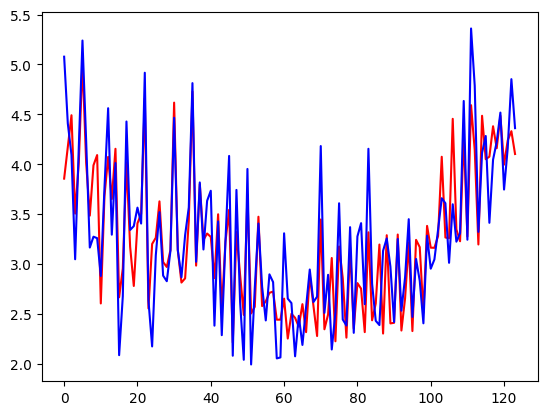

In [56]:
trange = np.arange(7700,7824)
tar = 11
# plt.figure(figsize=(10,5))
plt.plot(testpred[trange,tar],color='r', label='WindTrans')
plt.plot(testlabel[trange,tar],color='b', label='Groun Truth')
plt.show()

In [16]:
# model= torch.load(model_file)
# model.load_state_dict(torch.load(model_file))
num_train, _, num_vertex = trainX.shape
num_val = valX.shape[0]
num_test = testX.shape[0]
train_num_batch = math.ceil(num_train / batch_size)
val_num_batch = math.ceil(num_val / batch_size)
test_num_batch = math.ceil(num_test / batch_size)

# test model
log_file = 'data/Wind/log(tjWind)'
log = open(log_file, 'w')
log_string(log, '**** testing model ****')
log_string(log, 'loading model from %s' % model_file)
# model = torch.load(model_file)
log_string(log, 'model restored!')
log_string(log, 'evaluating...')

with torch.no_grad():
    # trainPred = []
    # for batch_idx in range(train_num_batch):
    #     start_idx = batch_idx * batch_size
    #     end_idx = min(num_train, (batch_idx + 1) * batch_size)
    #     X = trainX[start_idx: end_idx]
    #     TE = trainTE[start_idx: end_idx]
    #     pred_batch = model(X, TE)
    #     trainPred.append(pred_batch.detach().clone())
    #     del X, TE, pred_batch
    # trainPred = torch.from_numpy(np.concatenate(trainPred, axis=0))
    # trainPred = trainPred * std + mean

    # valPred = []
    # for batch_idx in range(val_num_batch):
    #     start_idx = batch_idx * batch_size
    #     end_idx = min(num_val, (batch_idx + 1) * batch_size)
    #     X = valX[start_idx: end_idx]
    #     TE = valTE[start_idx: end_idx]
    #     pred_batch = model(X, TE)
    #     valPred.append(pred_batch.detach().clone())
    #     del X, TE, pred_batch
    # valPred = torch.from_numpy(np.concatenate(valPred, axis=0))
    # valPred = valPred * std + mean

    testPred = []
    start_test = time.time()
    for batch_idx in range(test_num_batch):
        start_idx = batch_idx * batch_size
        end_idx = min(num_test, (batch_idx + 1) * batch_size)
        X = testX[start_idx: end_idx].to(device)
        TE = testTE[start_idx: end_idx].to(device)
        pred_batch = model(X, TE)
        testPred.append(pred_batch.detach().cpu().clone())
        del X, TE, pred_batch
    testPred = torch.from_numpy(np.concatenate(testPred, axis=0))
    testPred = testPred* std + mean
end_test = time.time()
# train_mae, train_rmse, train_mape = metric(trainPred, trainY)
# val_mae, val_rmse, val_mape = metric(valPred, valY)
# test_mae, test_rmse, test_mape = metric(testPred, testY)
log_string(log, 'testing time: %.1fs' % (end_test - start_test))
# log_string(log, '                MAE\t\tRMSE\t\tMAPE')
# log_string(log, 'train            %.2f\t\t%.2f\t\t%.2f%%' %
#            (train_mae, train_rmse, train_mape * 100))
# log_string(log, 'val              %.2f\t\t%.2f\t\t%.2f%%' %
#            (val_mae, val_rmse, val_mape * 100))
# log_string(log, 'test             %.2f\t\t%.2f\t\t%.2f%%' %
#            (test_mae, test_rmse, test_mape * 100))
# log_string(log, 'performance in each prediction step')
# MAE, RMSE, MAPE = [], [], []
# for step in range(num_pred):
#     mae, rmse, mape = metric(testPred[:, step], testY[:, step])
#     MAE.append(mae)
#     RMSE.append(rmse)
#     MAPE.append(mape)
#     log_string(log, 'step: %02d         %.2f\t\t%.2f\t\t%.2f%%' %
#                (step + 1, mae, rmse, mape * 100))
# average_mae = np.mean(MAE)
# average_rmse = np.mean(RMSE)
# average_mape = np.mean(MAPE)
# log_string(
#     log, 'average:         %.2f\t\t%.2f\t\t%.2f%%' %
#          (average_mae, average_rmse, average_mape * 100))



**** testing model ****
loading model from result/model/GT_bj5m_p4.pkl
model restored!
evaluating...
testing time: 14.6s
